## Instruction
In this notebook, we will complete backtest which is the last step.

In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import scipy
from scipy.optimize import fmin_l_bfgs_b
from sklearn.decomposition import PCA

from statistics import median
from scipy.stats import gaussian_kde, zscore
from statsmodels.formula.api import ols

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 4]

import warnings
warnings.filterwarnings('ignore')

### Load Factors
We have factors store in csv file which process and combine from privious steps. Pick up backtest time from 2022.4 - 2022.3

In [2]:
#fundamental_df = pd.read_csv('tmp_factor.csv').iloc[:,1:]
universe_raw = pd.read_csv('AI_data/factors_AI_119.csv').iloc[:,1:]
universe_raw['date'] = pd.to_datetime(universe_raw['trade_date'], format='%Y%m%d')
universe = universe_raw.set_index(['date']).sort_values(by=['date'])
universe = universe.fillna(method='ffill').fillna(0.)
print(universe.shape)

(95847, 10)


In [3]:
# only use from 2022.6 to 2023.4, here from 2022.5 in order to generate risk model from history
universe = universe.loc[universe['trade_date']>=20220401]
universe.columns

Index(['ts_code', 'trade_date', 'name', 'industry', 'close', 'log-ret',
       'alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI'],
      dtype='object')

### Alignment Tickers
fill data to history by 0 in order to get align ticker marix data each day.

In [4]:
def init_holding(df):
    ticker_list = df.ts_code.unique()
    calendar = df.trade_date.unique()
    for dt in tqdm(calendar):
        day_df = df.loc[df.trade_date == dt]
        diff_tickers = list(set(ticker_list) - set(day_df.ts_code.unique()))
        if len(diff_tickers) > 0:
            for ticker in diff_tickers:
                check_df = df.loc[df.ts_code==ticker].iloc[0,:]
                # date ts_code trade_date name industry close log-ret 'alpha_atr' 'alpha_kama' 'alpha_009' 'alpha_AI' 
                data = [pd.to_datetime(dt, format='%Y%m%d'), ticker, dt, check_df['name'],
                        check_df['industry'], 0., 0., 0., 0., 0., 0.]
                data = pd.DataFrame(data=data, index=np.append(['date'], df.columns)).T.set_index(['date'])
                df = df.append(data)
    df = df.sort_values(by=['date']) 
    return df

universe = init_holding(universe)

100%|█████████████████████████████████████████| 261/261 [00:04<00:00, 60.42it/s]


### Rescale AI Factor

In [5]:
def rescale_(data):
    # resize from -1 to 1
    feature = 'alpha_AI'
    data[feature] = data[feature].astype(np.float32)
    data[[feature]] = data[[feature]].apply(zscore)
    max_val = data[feature].median() + 3.5*data[feature].std()
    min_val = data[feature].median() - 3.5*data[feature].std()
    data[feature] = np.where(data[feature]>max_val, max_val, 
                           np.where(data[feature]<min_val, min_val, data[feature]))
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(),
                             np.where(data[feature]<0, data[feature]/(-data[feature].min()), 0.))
    return data

# need to fix excuted in privious step
def zscore_AI(data):
    feature = 'alpha_AI'
    data[feature] = data[feature].astype(np.float32)
    data[[feature]] = data[[feature]].apply(zscore)
    data[feature] = np.where(data[feature]>0, data[feature]/data[feature].max(), 
                                np.where(data[feature]<0, data[feature]/-data[feature].min(), 0.))
    return data

#universe_z = universe.groupby('trade_date').apply(rescale_)
universe_z = universe.groupby('trade_date')[universe.columns].apply(rescale_)

0.06350396


<AxesSubplot:>

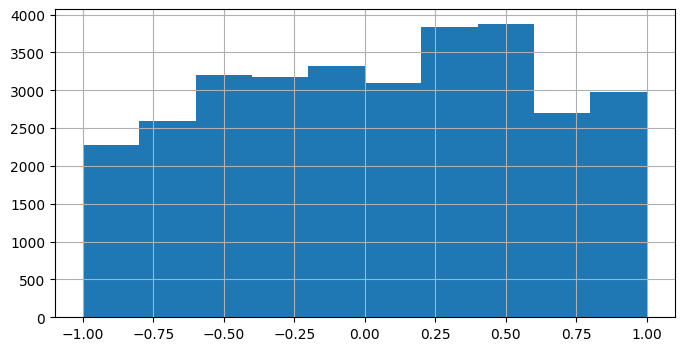

In [6]:
print(universe_z['alpha_AI'].median())
universe_z['alpha_AI'].hist()

### Factor Exposures and Factor Returns
The facort values in cross section should view as a type of exposure. We can calculate factor returns bettwen exposures of each ticker and daily return. We also did this in backtestig animate notebook.

In [7]:
## shif return 5 days
all_factors = universe_z.copy(deep=True)
#all_factors = all_factors.sort_values(by=['date'])
def return_handle(df):
    df['returns_2'] = df['log-ret'].shift(-2)
    return df
all_factors = all_factors.groupby('ts_code').apply(return_handle)
all_factors = all_factors.replace([np.inf, -np.inf], np.nan).fillna(0.).sort_values(by=['trade_date', 'ts_code'])
print(universe.shape, all_factors.shape)

(31059, 10) (31059, 11)


In [8]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n, name):
    return list(filter(lambda x: name in x, n))

def estimate_factor_returns(df, name='alpha_'): 
    ## winsorize returns for fitting 
    estu = df.copy(deep=True)
    estu['returns_2'] = wins(estu['returns_2'], -0.2, 0.2)
    all_factors = factors_from_names(list(df), name)
    results = pd.Series()
    for factor_name in all_factors:
        form = get_formula([factor_name], "returns_2")
        model = ols(form, data=estu)
        result = model.fit()
        results = results.append(result.params)
    return results

estimate_factor_returns(all_factors.loc[all_factors['trade_date']==20220601])

alpha_atr     0.018885
alpha_kama   -0.032943
alpha_009     0.021981
alpha_AI      0.002808
dtype: float64

In [50]:
base_field = ['ts_code','trade_date','name', 'industry', 'close', 'log-ret']
alpha_field = ['alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI'] 
date_and_code = [ 'trade_date','ts_code', 'returns_2']

start_time = 20220501
alpha_df = all_factors[alpha_field + date_and_code].copy(deep=True)
alpha_df = alpha_df.loc[alpha_df['trade_date']>=start_time]
calendar = alpha_df.trade_date.unique() # int64

#only for positive estimate
#for feature in alpha_field:
    #alpha_df[feature] = np.where(alpha_df[feature]>=0.8, alpha_df[feature], np.where(alpha_df[feature]<=-0.8, alpha_df[feature], 0))
#    alpha_df[feature] = np.where(alpha_df[feature]>0, alpha_df[feature], 0.)

facret = {}
for dt in tqdm(calendar, desc='regression factor returns'):
    facret[dt] = estimate_factor_returns(alpha_df.loc[alpha_df['trade_date']==dt])
facret[calendar[-5]]

regression factor returns: 100%|██████████████| 242/242 [00:05<00:00, 43.28it/s]


alpha_atr    -0.040477
alpha_kama   -0.027701
alpha_009    -0.035693
alpha_AI     -0.025308
dtype: float64

#### Veiw Factor Returns

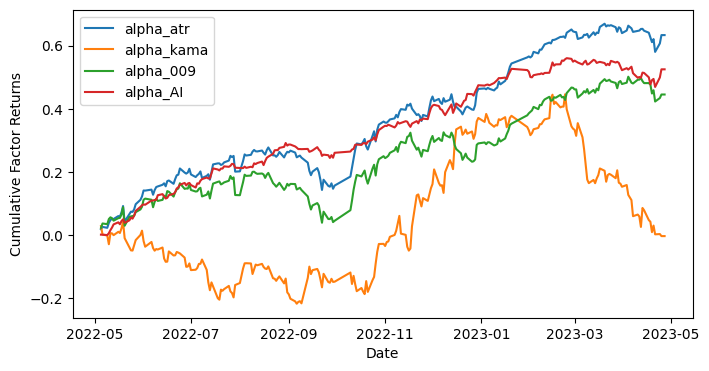

In [51]:
date_list = alpha_df.index.unique()
facret_df = pd.DataFrame(index = date_list)

for ii, dt in zip(calendar,date_list): 
    for alp in alpha_field: 
        facret_df.at[dt, alp] = facret[ii][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

In [23]:
universe = universe.loc[universe['trade_date']>=20220401]
all_factors = all_factors.loc[all_factors['trade_date']>=20220401]

In [24]:
# for feature in alpha_field:
#     all_factors[feature] = np.where(all_factors[feature]>=0.85, all_factors[feature],
#                                     np.where(all_factors[feature]<=-0.85, all_factors[feature], 0))
all_factors.tail()

,ts_code,trade_date,name,industry,close,log-ret,alpha_atr,alpha_kama,alpha_009,alpha_AI,returns_2
date,,,,,,,,,,,
2023-04-27,688363.SH,20230427,华熙生物,医疗保健,99.45,0.028042,-0.347717,-0.093978,-0.633329,-0.452059,0.0
2023-04-27,688579.SH,20230427,山大地纬,软件服务,15.45,0.042306,0.162151,-0.000219,0.757856,-0.367806,0.0
2023-04-27,688589.SH,20230427,力合微,半导体,43.59,-0.013897,-0.199810,-0.034529,-0.100953,-0.565704,0.0
2023-04-27,688655.SH,20230427,迅捷兴,元器件,12.05,-0.002487,0.761269,0.026345,0.918403,0.899732,0.0
2023-04-27,688799.SH,20230427,华纳药厂,化学制药,41.79,0.031602,-0.003952,0.017715,-0.034357,-0.381824,0.0


### PCA model
We use PCA algorithm to estimate risk

In [25]:
from sklearn.decomposition import PCA

class RiskModel(object):
    def __init__(self, returns, num_factor_exposures, ann_factor=20):
        
        self.num_factor_exposures = num_factor_exposures
        self.pca = PCA(n_components=num_factor_exposures, svd_solver='full')
        self.pca.fit(returns)
        
        self.factor_betas_ = self.factor_betas(self.pca, returns.columns.values, np.arange(num_factor_exposures))
        self.factor_returns_ = self.factor_returns(self.pca, returns, returns.index, np.arange(num_factor_exposures))
        self.estimate_returns = self.estimate_returns(self.factor_returns_, self.factor_betas_, returns)
        self.factor_cov_matrix_ = self.factor_cov_matrix(self.factor_returns_, ann_factor)
        
        self.idiosyncratic_var_matrix_ = self.idiosyncratic_var_matrix(returns, self.estimate_returns, ann_factor)
        self.idiosyncratic_var_vector = pd.DataFrame(data=np.diag(self.idiosyncratic_var_matrix_),
                                                     index=returns.columns)
    
    # got new exposure expressed by pca model
    def factor_betas(self, pca, factor_beta_indices, factor_beta_columns):
        return pd.DataFrame(pca.components_.T, factor_beta_indices, factor_beta_columns)
    
    # got new factor returns expressed by pca model
    def factor_returns(self, pca, returns, factor_return_indices, factor_return_columns):
        return pd.DataFrame(pca.transform(returns), factor_return_indices, factor_return_columns)
    
    # got new factor covariance matirx by pca expressed returns
    def factor_cov_matrix(self, factor_returns, ann_factor):
        return np.diag(factor_returns.var(axis=0, ddof=1) * ann_factor)
    
    def estimate_returns(self, factor_returns, factor_betas, returns):
        return pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    
    # calculate idiosyncratic need to got factor_returns, factor_betas which calculate by pca model first
    def idiosyncratic_var_matrix(self, returns, estimate_returns, ann_factor):
        residuals = returns - estimate_returns
        return pd.DataFrame(np.diag(np.var(residuals))*ann_factor, returns.columns, returns.columns)
    
    def plot_principle_risk(self):
        # Make the bar plot
        plt.bar(np.arange(self.num_factor_exposures), self.pca.explained_variance_ratio_)

In [26]:
def rolling_df_by_day(df, start_time):
    pca_time_window = len(df.loc[df['trade_date']<start_time].trade_date.unique())
    print(f'pca window_len is {pca_time_window}')
    #trade_date_list = df.loc[df['trade_date']>=start_time].trade_date.unique()
    all_date_list = df.trade_date.unique()
    for start_i in range(len(all_date_list)):
        start_date = all_date_list[start_i]
        if start_i + pca_time_window >= len(all_date_list):
            break
        end_date = all_date_list[start_i + pca_time_window]
        yield end_date, df.loc[(df['trade_date']>=start_date) & (df['trade_date']<=end_date)]
        
def risk_by_PCA(returns_df):
#     for col in returns_df.columns:
#         returns_df[col] = np.where(returns_df[col]<0, returns_df[col], 0.)
    
    # Set the number of factor exposures (principal components) for the PCA algorithm
    num_factor_exposures = 5
    # Create a RiskModel object
    rm = RiskModel(returns_df, num_factor_exposures)
    
    B = rm.factor_betas_
    F = rm.factor_cov_matrix_
    S = rm.idiosyncratic_var_matrix_
    fr = rm.factor_returns_
    #fr = rm.estimate_returns
    
    variance = np.dot(B, F).dot(B.T) + S
    return variance, B, fr, rm.idiosyncratic_var_vector, F

# test
dt, df = next(rolling_df_by_day(all_factors, start_time))
returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
variance_i, B, risk_fr, residual_i, F = risk_by_PCA(returns_df)
print(f'return date {dt}')
variance_i.head()

pca window_len is 19
return date 20220505


ts_code,000411.SZ,000756.SZ,000915.SZ,002322.SZ,002362.SZ,002365.SZ,002380.SZ,002393.SZ,002462.SZ,002577.SZ,...,688244.SH,688259.SH,688314.SH,688317.SH,688358.SH,688363.SH,688579.SH,688589.SH,688655.SH,688799.SH
ts_code,,,,,,,,,,,,,,,,,,,,,
000411.SZ,0.030911,0.025409,0.022867,0.017040,0.016826,0.022894,0.012162,0.015970,0.019285,0.018788,...,0.0,0.012880,0.017102,0.028487,0.016949,0.012362,0.019969,0.025590,0.024596,0.016542
000756.SZ,0.025409,0.090557,0.024420,0.008213,0.012799,0.025826,0.002741,0.014128,0.020869,0.016003,...,0.0,0.007782,0.013742,0.017511,0.009201,0.021137,0.012363,0.019299,0.009644,0.013748
000915.SZ,0.022867,0.024420,0.037553,0.015260,0.015355,0.019365,0.011432,0.013151,0.014439,0.016342,...,0.0,0.013420,0.016280,0.024297,0.014660,0.014476,0.017621,0.025840,0.022518,0.013642
002322.SZ,0.017040,0.008213,0.015260,0.020683,0.011971,0.017477,0.011008,0.011217,0.011634,0.014280,...,0.0,0.010416,0.012146,0.022611,0.014115,0.009387,0.015802,0.017418,0.021501,0.011414
002362.SZ,0.016826,0.012799,0.015355,0.011971,0.014446,0.012097,0.008858,0.009796,0.011349,0.011858,...,0.0,0.010096,0.011677,0.018875,0.012054,0.007319,0.014636,0.018667,0.018872,0.010180


In [29]:
h=np.array([1/119]*119) 
(np.dot(h, variance_i).dot(h.T))** 0.5

0.12701245190940083

In [30]:
variance_all = {}
residual_df = pd.DataFrame()

for dt, df in rolling_df_by_day(all_factors, start_time):
    ticker_list = all_factors.loc[all_factors.trade_date==dt].ts_code.unique()
    df = df.loc[df.ts_code.isin(ticker_list)]
    returns_df = df.pivot(index='trade_date', columns='ts_code', values='log-ret').fillna(0)
    variance_i, B, risk_factor, residual_i, F = risk_by_PCA(returns_df)
    variance_all[dt] = [variance_i, B, risk_factor.iloc[-1,:], residual_i.copy(), F]
    residual_i['trade_date'] = df.loc[df.index[-1],'trade_date'].unique()[-1]
    residual_df = residual_df.append(residual_i)

residual_df.reset_index(inplace=True)
residual_df.columns = ['ts_code', 'residual', 'trade_date']
residual_df['residual'] = np.where(residual_df['residual'].isnull(), residual_df['residual'].median(), residual_df['residual'])
all_factors = all_factors.loc[all_factors['trade_date']>=start_time]
all_factors = all_factors.merge(residual_df, on=['trade_date','ts_code'], how='left')
#all_factors.tail()
print(residual_df.shape, all_factors.shape)

pca window_len is 19
(28798, 3) (28798, 12)


### (Optional) Store Residual

In [ ]:
#universe = universe.merge(residual_df, on=['ts_code', 'trade_date'], how='left')
#universe = universe.rename(columns={'residual': 'alpha_resi'})
#universe = universe.loc[universe['trade_date']>=start_time]

In [ ]:
#universe['alpha_resi'].hist()

In [ ]:
# universe['alpha_resi'] = universe['alpha_resi'] * 1000
# universe.to_csv('AI_data/factors_AI_108_residual.csv')

### Combine Factors

In [62]:
#'alpha_atr14', 'alpha_kama', 'alpha_AI'
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
alpha_df = all_factors.drop(columns=['returns_2']).set_index(['date', 'ts_code']).sort_index(level=['ts_code'])
alpha_df['alpha_all'] = 0.4 * alpha_df['alpha_AI'] + 0.6 * alpha_df['alpha_atr']
#alpha_df['alpha_all'] = 0.35*alpha_df['alpha_kama'] + 0.65*alpha_df['alpha_009']
print(max(alpha_df['alpha_all']), min(alpha_df['alpha_all']))

1.0000000059604646 -1.0000000059604646


In [63]:
# for dt in alpha_df.index.get_level_values(0):
#     tmp = alpha_df.loc[dt]
#     print(tmp['trade_date'])

### Backtest by Convex Optimization(Choice one option)

### Option One
- use `cvxpy` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed max risk to endure

In [64]:
calendar = alpha_df.trade_date.unique()
ticker_num = len(alpha_df.index.get_level_values(1).unique())

# get parameter
positions = {}
alpha_df['h_privious'] = 0.
h0 = [0.] * ticker_num
aversion = 0.1
Lambda = 2e-3

In [65]:
from helper.project_helper import OptimalHoldings

dt = 20230426
obj_df = alpha_df.loc[alpha_df.trade_date==dt]
alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
optimal_weights = OptimalHoldings(aversion=.1, weights_max=0.3).find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'], Lambda = 2e-6)
optimal_weights.loc[optimal_weights[0]>=0.01]

,0
ts_code,
000411.SZ,0.021367
002322.SZ,0.094800
002365.SZ,0.153508
002788.SZ,0.141081
002826.SZ,0.078595
300016.SZ,0.202606
300485.SZ,0.108245
300918.SZ,0.051032
600513.SH,0.090372


In [66]:
for dt in tqdm(calendar, desc='optimized holding...'):
    # fill yesterday holding
    obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    alpha_vector = obj_df.loc[obj_df.index.get_level_values(0)[-1]][['alpha_all']]
    # convex optimize
    optimal_weights = OptimalHoldings(aversion=.1, weights_max=0.25).find(alpha_vector, variance_all[dt][1],
                            variance_all[dt][4],  variance_all[dt][3], obj_df['h_privious'],Lambda = 2e-6)
    h_optimal = optimal_weights
    # update optimize holding
    obj_df['h_opt'] = h_optimal.values
    obj_df['h_privious'] = h0
    positions[dt]= obj_df
    h0 = h_optimal.values

optimized holding...: 100%|███████████████████| 242/242 [07:29<00:00,  1.86s/it]


### Option Two
- use `scipy.optimize.fmin_l_bfgs_b` to optimized portfolio
- lambda expressed a transaction costs weights
- aversion expressed a risk 1 posistion map to reduce how much risk

In [ ]:
# the lambda expressed a transaction costs weights
def get_obj_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4): 
    def obj_func(h):
        #f = 0.5 * aversion * np.dot(h, variance).dot(h.T) - aversion * np.matmul(h, alpha) + np.dot((h-h0)**2, Lambda)
        f =  - np.matmul(h, alpha) \
             + 0.5 * aversion * (np.dot(h, variance).dot(h.T)) \
             + np.dot((h-h0)**2, Lambda) 
             
        return f
    return obj_func

def get_grad_func(h0, variance, alpha, Lambda=3e-6, aversion=1e-4):
    def grad_func(h):
        #f_hat =  aversion * np.dot(variance, h) - aversion * alpha + 2 * Lambda * (h-h0)
        f_hat =  - alpha  \
                + aversion * np.dot(variance, h) \
                + 2 * Lambda * (h-h0) 
        return f_hat
    return grad_func

# get parameter
bounds = [(0, 10000)] * ticker_num

# for dt in calendar:
#     # fill yesterday holding
#     obj_df = alpha_df.loc[alpha_df.trade_date==dt]
    
#     # convex optimize
#     obj_func = get_obj_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     grad_func = get_grad_func(h0, variance_all[dt][0], obj_df['alpha_all'].values)
#     h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func, bounds=bounds)
#     #h_optimal, min_val, _ = fmin_l_bfgs_b(obj_func, h0, fprime=grad_func)
#     # update optimize holding
#     obj_df['h_opt'] = h_optimal
#     obj_df['h_privious'] = h0
#     positions[dt]= obj_df
#     h0 = h_optimal

1.0000000005137706 0.9999999999098539
1.0000000000047402 1.0000000000001608


<AxesSubplot:>

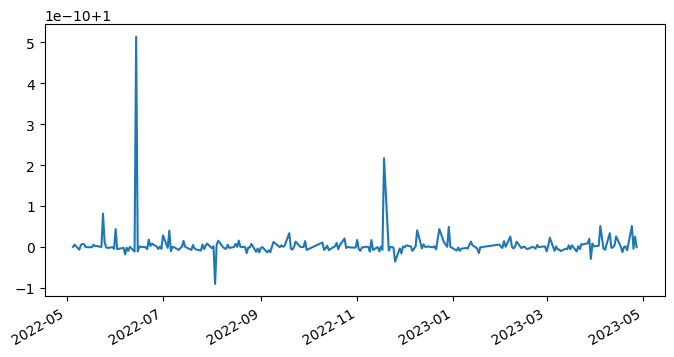

In [67]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))
print(np.mean(all_positions), np.median(all_positions))
#positions[20230315]['h_opt'].hist()
calendar = all_factors['trade_date'].unique()
pd.Series(all_positions, index=pd.to_datetime(calendar, format='%Y%m%d')).plot()

### Normalize optimal sum to 1

In [68]:
holding_money = 2e5
for i in positions.keys():
    positions[i]['h_opt'] = positions[i]['h_opt'] * holding_money
    positions[i]['h_privious'] = positions[i]['h_privious'] * holding_money

h_optimal_list = [positions[dt]['h_opt'] for dt in positions.keys() ]
h_privious_list = [positions[dt]['h_privious'] for dt in positions.keys() ]

In [69]:
all_positions = []
for dt in list(positions.keys()):
    all_positions.append(positions[dt].h_opt.sum())
print(max(all_positions), min(all_positions))

200000.0001027541 199999.99998197076


199999.99999921242 (8, 13)


name  close   log-ret    h_privious         h_opt
date       ts_code                                                     
2023-04-25 002365.SZ  永安药业  10.22 -0.029882  33892.179393  36943.160152
           002788.SZ  鹭燕医药   8.91 -0.028763  28433.249431  32453.779235
           002826.SZ  易明医药  10.08 -0.031253  19521.334811  21472.064834
           300016.SZ  北陆药业   6.24 -0.051534  37305.015167  41166.857466
           300485.SZ  赛升药业  10.67 -0.034994  24806.964021  27647.288241
           300918.SZ  南山智尚  10.85 -0.030855   8520.221079  11993.874141
           600513.SH  联环药业  10.38 -0.042439  24442.431415  17867.665128
           603386.SH  骏亚科技  11.46 -0.024991   9120.762690  10455.310796

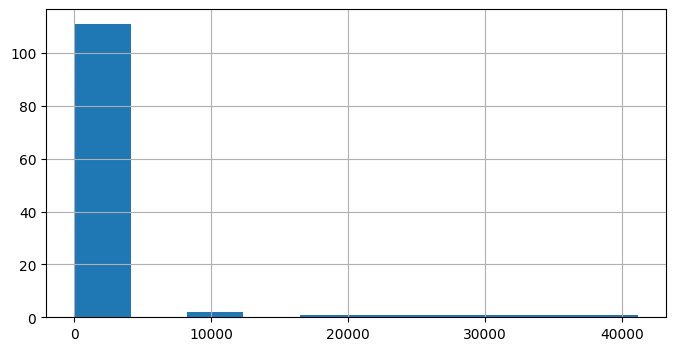

In [72]:
date_hold = 20230425
positions[date_hold]['h_opt'].hist()
tmp = positions[date_hold].loc[positions[date_hold]['h_opt']>=0.1]
print(positions[date_hold].loc[positions[date_hold]['h_opt']>0]['h_opt'].sum(), tmp.shape)
tmp[['name', 'close','log-ret','h_privious', 'h_opt']]

### Calculate Exposure and Transaction Costs
We use pca to calculate risk, so we can view residual(alpha) as risk exposure.

<AxesSubplot:title={'center':'Risk Exposure'}>

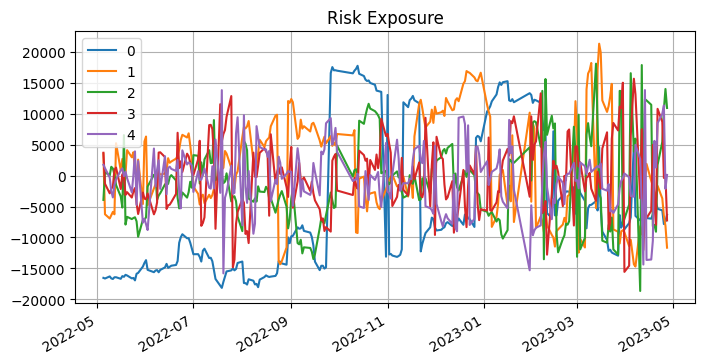

In [73]:
#plt.rcParams['figure.figsize'] = [7, 3]
risk_exposures_df = pd.DataFrame()
risk_exposures = {}
for ii, dt in enumerate(positions.keys()):
    # estimate_returns = pd.DataFrame(np.dot(factor_returns, factor_betas.T), returns.index, returns.columns)
    B = variance_all[dt][1]
    h_opt_i = h_optimal_list[ii]
    risk_exposure = np.matmul(h_opt_i.T, B)
    risk_exposures[dt] = risk_exposure
    risk_exposures_df = risk_exposures_df.append(risk_exposure, ignore_index=True)

#np.sum(risk_exposures)
risk_exposures_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
risk_exposures_df.plot(grid=True, title='Risk Exposure')
#risk_exposures_df.head()

### Alpha Exposure

<AxesSubplot:>

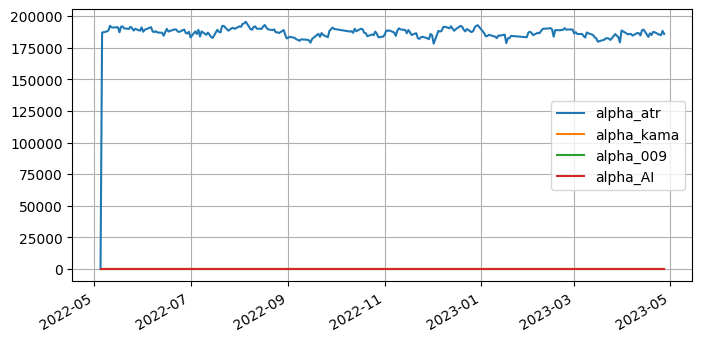

In [80]:
import patsy
import pandas

def colnames(B):
    if type(B) == patsy.design_info.DesignMatrix: 
        return B.design_info.column_names
    if type(B) == pandas.core.frame.DataFrame: 
        return B.columns.tolist()
    return None

def get_B_alpha(universe):
    alpha_factors = factors_from_names(list(universe),'alpha_')
    formula = get_formula(alpha_factors, "returns_2")
    outcome, B_alpha = patsy.dmatrices(formula, universe)
    return B_alpha

alpha_df_ = alpha_df.merge(all_factors[['trade_date','ts_code','returns_2']], on=['trade_date','ts_code'], how='left')
calendar = alpha_df.trade_date.unique()
alpha_exposure_df = pd.DataFrame()
alpha_exposures = {}
for ii, dt in enumerate(calendar):
    alpha_df_i = alpha_df_.loc[alpha_df_.trade_date==dt][['trade_date','ts_code',
                            'alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI', 'returns_2']]
    h_opt_i = h_privious_list[ii]
    B_alpha = get_B_alpha(alpha_df_i)
    
    # alpha_df['alpha_all'] = 0.7 * alpha_df['alpha_AI'] + 0.3*alpha_df['alpha_149'] + 0.1*alpha_df['alpha_010']
    B_alpha = B_alpha * [[1.0, 0.0, 0.0, 0.0]] #* len(alpha_df_.ts_code.unique())
    #alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=colnames(B_alpha))
    alpha_exposure = pd.Series(np.matmul(B_alpha.transpose(), h_opt_i), index=['alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI'])
    alpha_exposures[dt] = alpha_exposure
    alpha_exposure_df = pd.concat([alpha_exposure_df,alpha_exposure], axis=1)

alpha_exposure_df = alpha_exposure_df.T.reset_index(drop=True)
alpha_exposure_df.set_index(pd.to_datetime(calendar, format='%Y%m%d'), inplace=True)
alpha_exposure_df.plot(grid=True)

15214.729125211525 -37613.3312753767


<AxesSubplot:>

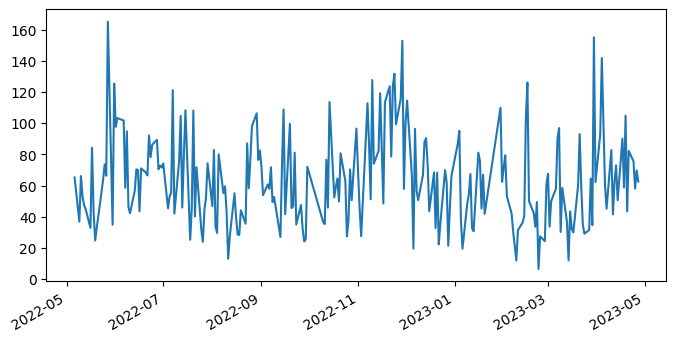

In [81]:
transaction_costs = []
retre_max = 0
Lambda = 2e-6
for i in range(1,len(h_optimal_list)):
    tmp_change = h_optimal_list[i] - h_privious_list[i]
    if min(tmp_change)<retre_max:
        retre_max = min(tmp_change)
    costs = sum(np.dot(tmp_change**2, Lambda)**0.5)
    transaction_costs.append(costs)
print(sum(transaction_costs),retre_max)
pd.Series(transaction_costs, index=pd.to_datetime(calendar[1:], format='%Y%m%d')).plot()

### Cal BenchMark

In [82]:
benchmark_return = pd.read_csv('AI_data/benmark_AI_119.csv')
benchmark_return.columns = ['trade_date', 'log-ret']
benchmark_return.tail()

,trade_date,log-ret
1044,20230421,-0.022071
1045,20230424,-0.009274
1046,20230425,-0.019098
1047,20230426,-0.004018
1048,20230427,0.000463


### Profit-and-Loss (PnL)

2023-04-21 00:00:00


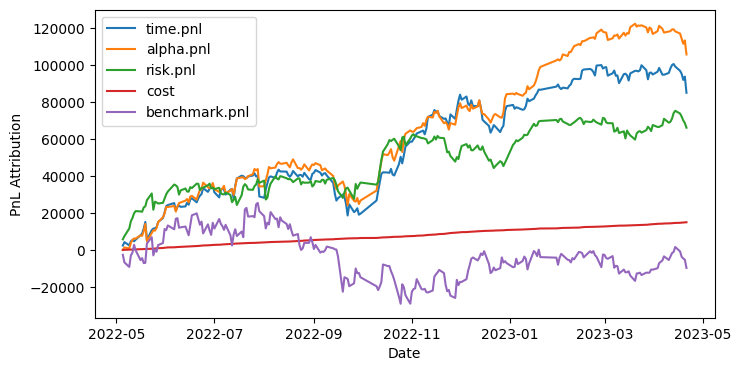

In [83]:
all_factors['date'] = pd.to_datetime(all_factors['trade_date'], format='%Y%m%d')
all_factors = all_factors.set_index(['date']).sort_values(by=['date'])

## assumes v, w are pandas Series 
def partial_dot_product(v, w):
    common = v.index.intersection(w.index)
    return np.sum(v[common] * w[common])

def build_pnl_attribution(): 

    df = pd.DataFrame(index = pd.to_datetime(all_factors['trade_date'].unique(), format='%Y%m%d')).iloc[:-4,:]
    calendar = all_factors.trade_date.unique()
    counter = range(len(calendar))
    for ii, dt, time_i in zip(counter,calendar,df.index):
        # holding frame
        p = positions[dt]
        # alpha f
        #fr = facret[dt][[0,2,5]]
        fr = facret[dt].loc[['alpha_atr', 'alpha_kama', 'alpha_009', 'alpha_AI']]
        # risk f
        rr = variance_all[dt][2]
        row_universe = all_factors.loc[all_factors.trade_date==dt]
        mf = p[['h_privious', 'h_opt']].merge(row_universe[['ts_code', 'returns_2']], how = 'left', on = "ts_code")  
        mf['returns_2'] = wins(mf['returns_2'], -0.2, 0.2)
        df.at[time_i,"time.pnl"] = np.sum(mf['h_opt'] * mf['returns_2'])
        df.at[time_i,"alpha.pnl"] = partial_dot_product(fr, alpha_exposures[dt])
        df.at[time_i,"risk.pnl"] = partial_dot_product(rr, risk_exposures[dt])
        #df.at[time_i,"risk.pnl"] = np.sum(rr.values * risk_exposures[dt].values)
        df.at[time_i,"cost"] = transaction_costs[ii]
        df.at[time_i,"benchmark.pnl"] = positions[dt]['h_opt'].sum() * \
                            benchmark_return.loc[benchmark_return.trade_date==dt]['log-ret'].values[0]
    
    print(time_i)
    return df

attr = build_pnl_attribution()
for column in attr.columns:
    plt.plot(attr[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('PnL Attribution')
plt.show()

In [84]:
attr['time.pnl'].sum()

85056.57152912414

In [79]:
attr['time.pnl'].cumsum().min()

2413.6599806621684

In [49]:
attr['benchmark.pnl'].sum()

-9675.655026066088